# ACCEL IMPLEMENTATION

In [1]:
import os
import time
import torch
import wandb
import imageio
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random

from dataclasses import dataclass, asdict
import copy


from PIL import Image
from collections import deque
from gymnasium.spaces import Box

from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Goal, Wall
from minigrid.minigrid_env import MiniGridEnv, Grid
from minigrid.wrappers import ImgObsWrapper

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_MODE"] = "disabled"

device = 'cpu'
print(f"Using device: {device}")

# ====================================================
# Custom MiniGrid Environment 
# ====================================================
class MyCustomGrid(MiniGridEnv):
    """
    Simple MiniGrid environment that places random wall tiles
    according to a config dict, returning only the 'image' observation.
    """

    def __init__(self, config=None, solvable_only=False, **kwargs):
        if config is None:
            config = {}
        self.config = config
        self.solvable_only = solvable_only

        # Create a random number generator with the custom seed
        self.rng = np.random.default_rng(seed=self.config.get("seed_val"))

        mission_space = MissionSpace(mission_func=lambda: "get to the green goal square")

        super().__init__(
            grid_size=self.config['width'],
            max_steps=self.config['width'] * self.config['height'] * 2, # max_steps is typically 2x the grid size
            see_through_walls=False,
            agent_view_size=5,                      # Size of the agent's view square
            mission_space=mission_space,
            **kwargs
        )

        # Manually define our observation_space as a single Box (the image).
        # By default, MiniGrid's image shape is (view_size, view_size, 3) if using partial obs,
        # or (height, width, 3) if using full-grid observation. We'll do full-grid here:
        # We'll define (self.height, self.width, 3) as the shape.
        # In practice, "image" shape can vary if partial observations are used.
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(self.agent_view_size, self.agent_view_size, 3),
            dtype=np.uint8
        )

            
    def _gen_grid(self, width, height):
        """
        Generate a new environment layout ensuring solvability if required.
        """
        
        check_stuck = 0
        while True:  # Keep regenerating until a solvable layout is found
            self.grid = Grid(width, height)
            self.grid.wall_rect(0, 0, width, height)

            # Place the goal
            goal_pos = self.config.get("goal_pos")
            if goal_pos is None:
                while True:
                    goal_r = self.rng.integers(1, height - 1)
                    goal_c = self.rng.integers(1, width - 1)
                    if self.grid.get(goal_c, goal_r) is None:
                        self.put_obj(Goal(), goal_c, goal_r)
                        self.config["goal_pos"] = (goal_c, goal_r)
                        break
            else:
                self.put_obj(Goal(), goal_pos[0], goal_pos[1])

            # Place the agent
            start_pos = self.config.get("start_pos")
            if start_pos is None:
                while True:
                    start_r = self.rng.integers(1, height - 1)
                    start_c = self.rng.integers(1, width - 1)
                    if self.grid.get(start_c, start_r) is None and (start_c, start_r) != self.config["goal_pos"]:
                        self.agent_pos = (start_c, start_r)
                        self.agent_dir = self.rng.integers(0, 4)
                        self.config["start_pos"] = (start_c, start_r)
                        break
            else:
                self.agent_pos = start_pos
                self.agent_dir = self.rng.integers(0, 4)
                self.config["start_pos"] = start_pos
            
            placed_blocks = 0
            
            # Maximum number of tries to place the blocks
            max_num_tries = 300
            
            # Place random walls using config parameters
            while placed_blocks < self.config["num_blocks"]:
                max_num_tries -= 1
                r = self.rng.integers(1, height - 1)
                c = self.rng.integers(1, width - 1)
                if max_num_tries <= 0:
                    print("Could not place all blocks in the grid.")
                    break
                if self.grid.get(c, r) is None and (c, r) != self.config["start_pos"] and (c, r) != self.config["goal_pos"]:
                    self.put_obj(Wall(), c, r)
                    placed_blocks += 1

            # Check solvability if required
            if not self.solvable_only or self._is_solvable():
                break
            
            check_stuck += 1
            if check_stuck > 50:
                #print("Re-randomizing start and goal positions...")
                self.config.pop("start_pos", None)
                self.config.pop("goal_pos", None)
                self.rng = np.random.default_rng(seed=self.config.get("seed_val") + check_stuck)

        
    def _is_solvable(self):
        """
        Uses Breadth-First Search (BFS) to check if there's a path 
        from the agent's start position to the goal.
        """
        start_pos = self.config["start_pos"]
        goal_pos = self.config["goal_pos"]
        if not start_pos or not goal_pos:
            return False

        queue = deque([start_pos])
        visited = set()
        visited.add(start_pos)

        while queue:
            x, y = queue.popleft()
            if (x, y) == goal_pos:
                return True

            # Possible moves: up, down, left, right
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                cell_obj = self.grid.get(nx, ny)
                if (
                    1 <= nx < self.width - 1 and  # Stay within grid bounds
                    1 <= ny < self.height - 1 and
                    (nx, ny) not in visited and
                    self.grid.get(nx, ny) is None or isinstance(cell_obj, Goal)
                ):
                    queue.append((nx, ny))
                    visited.add((nx, ny))
        return False  # No path found

    def reset(self, **kwargs):
        """
        Override reset to ensure we only return the 'image' array
        instead of a dict with 'image' and 'mission'.
        """
        obs, info = super().reset(**kwargs)
        obs = self._convert_obs(obs)
        
        return obs, info

    def step(self, action):
        """
        Same for step: override to convert the dict observation into an image only.
        """
        obs, reward, done, truncated, info = super().step(action)
        obs = self._convert_obs(obs)
        return obs, reward, done, truncated, info

    def _convert_obs(self, original_obs):
        """
        original_obs is typically {'image':..., 'mission':...}.
        We'll just return original_obs['image'] to get a Box(low=0,high=255) shape.
        """
        return original_obs["image"]
        #return np.transpose(original_obs["image"], (2, 0, 1))
    
    def update_config(self, new_config):
        """
        Update the environment configuration with a new config dict.
        """
        self.config = new_config
        self.reset()

def random_config(grid_size, num_blocks=None, seed=None):
    """
    Utility function to generate a random configuration dict.
    """
    
    max_blocks = int(((grid_size - 1) * (grid_size - 1)) / 2)
    
    if num_blocks is None:
        num_blocks = np.random.randint(1, max_blocks)
    else:
        num_blocks = min(num_blocks, max_blocks)
        
    config = {
        "width": grid_size,
        "height": grid_size,
        "num_blocks": num_blocks,
        "start_pos": None,
        "goal_pos": None,
        "edited": False,
        "seed_val": seed if seed is not None else np.random.randint(0, 1000)
    }
    
    # Set the start and goal positions
    env = MyCustomGrid(config)
    
    # Reset the environment to get the start and goal positions
    env.reset()
    
    # Get the new config from the environment
    config = env.config
        
    return config

def print_level_from_config(config, solvable_only=False):
    """
    Function to display a level configuration as an image.
    """
    
    env = MyCustomGrid(config, render_mode='rgb_array', solvable_only=solvable_only)
    env.reset()
    full_level_image = env.render()  # This should return an RGB image of the full grid

    plt.figure(figsize=(4, 4))
    plt.imshow(full_level_image)
    plt.title("Level Configuration: " + str(config))
    plt.axis("off")
    plt.show()
    
def edit_config(old_config):
    """
    Make a little edit to an existing configuration.
    """
    
    # Modify an existing configuration, adding randomness.
    max_blocks = int(((old_config["width"] - 1) * (old_config["height"] - 1)) / 2)
    
    new_config = dict(old_config)
    
    # Randomly change the number of blocks
    new_number_blocks = old_config["num_blocks"] + np.random.choice([-2, -1, 1, 2])
    
    # Ensure the number of blocks is within bounds
    new_config["num_blocks"] = max(1, min(new_number_blocks, max_blocks))    
    
    # Mark the config as edited
    new_config["edited"] = True
    
    return new_config

def create_vectorized_env(config, n_envs=4, solvable_only=False):
    """
    Create a vectorized environment with n parallel environments.
    """
    return make_vec_env(lambda: MyCustomGrid(config, solvable_only), n_envs=n_envs, vec_env_cls=SubprocVecEnv)

# ====================================================
# Level Buffer
# ====================================================
class LevelBuffer: 
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []  # will store (config_dict, score)

    def add(self, config, score):
        self.data.append((config, score))
        if len(self.data) > self.max_size:
            self.data.sort(key=lambda x: x[1], reverse=True)
            self.data = self.data[: self.max_size]
            #it memorize only the highest score for each level

    def sample_config(self): 
        # Samples a level from the buffer, weighting the probabilities 
        # based on the scores.
        if len(self.data) == 0:
            return None
        scores = [item[1] for item in self.data]
        total = sum(scores)
        if total <= 1e-9:
            # fallback to uniform
            idx = np.random.randint(len(self.data))
            return self.data[idx][0]
        probs = [s / total for s in scores]
        idx = np.random.choice(len(self.data), p=probs)
        return self.data[idx][0]

# ====================================================
# Test Functions
# ====================================================
def load_models(grid_size):
    """Load the RL models."""
    model_dr = PPO.load(f"models/dr_model_{grid_size}x{grid_size}")
    model_plr = PPO.load(f"models/plr_model_{grid_size}x{grid_size}")
    model_accel = PPO.load(f"models/accel_model_{grid_size}x{grid_size}")
    model_accel_easy = PPO.load(f"models/accel_model_easy_{grid_size}x{grid_size}")
    print(f"Models trained on {grid_size}x{grid_size} grid loaded successfully.")
    
    return model_dr, model_plr, model_accel, model_accel_easy

def evalute_models(load_dim = -1, grid_size = 6, n_eval_episodes = 5, num_levels_per_difficulty = 10):
    
    if load_dim > 0:
        model_dr, model_plr, model_accel, model_accel_easy = load_models(load_dim)
        
    # Inseert the models in a dictionary
    models = {"DR": model_dr, 'PLR': model_plr, 'ACCEL': model_accel, 'ACCEL-EasyStart': model_accel_easy}

    # Generate n levels difficulties with increasing complexity, for each level generate m configs
    difficulties = 3
    num_levels_per_difficulty = num_levels_per_difficulty

    levels = []
    for i in range(difficulties):
        level = []
        for _ in range(num_levels_per_difficulty):
            cfg = random_config(grid_size, num_blocks=grid_size*(i+1))
            #print_level_from_config(cfg, solvable_only=True)
            level.append(cfg)
        levels.append(level)
        
    
    # Create a dummy config to initialize the vectorized environment
    dummy_config = random_config(grid_size)
    env = create_vectorized_env(dummy_config, n_envs=4, solvable_only=True)

    # Evaluate the model on the generated levels
    results = {}
    for model_name, model in models.items():
        results[model_name] = []
        for i, level in enumerate(levels):
            print(f"Evaluating {num_levels_per_difficulty} levels of difficulty {i + 1} with {grid_size*(i+1)} blocks on a {grid_size}x{grid_size} grid for model {model_name}, ratio of blocks to grid size: {grid_size*(i+1) / (grid_size*grid_size):.2f}")
            r = []
            for j, cfg in enumerate(level):
                # Update the environment with the new config
                env.env_method("update_config", cfg)
                mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, deterministic=True)
                r.append(mean_reward)
            results[model_name].append(r)
        print()
        
    # Print mean rewards for each level
    for model_name in models.keys():
        print(f"Model: {model_name}")
        for i, level in enumerate(levels):
            print(f"Level {i + 1} - Complexity {grid_size*(i+1)}: {np.mean(results[model_name][i]):.2f}")
        print()
    
    #Comute the number of xticks based on the number of models
    xticks = [i for i in range(1, len(models.keys()) + 1)]

    # Boxplot of results, a plot for each level complexity comparing models
    plt.figure(figsize=(12, 6))
    for i, level in enumerate(levels):
        plt.subplot(1, difficulties, i + 1)
        plt.boxplot([results[model_name][i] for model_name in models.keys()])
        plt.xticks([1,2,3,4], [model_name for model_name in models.keys()])
        plt.title(f"Level {i + 1} - Complexity {grid_size*(i+1)}")
        plt.ylabel("Mean Reward")
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    plt.savefig(f"plots/boxplot_{load_dim}x{load_dim}.png")
    
def test_model(model, config, gif_path="level.gif", max_steps=1000):
    """Evaluate a model on a given environment instance."""
    env = MyCustomGrid(config, render_mode='rgb_array', solvable_only=True)
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    i = 0

    frames = []  # List to store frames

    # Continue until either terminated or truncated is True
    while not (terminated or truncated):
        frame = env.render()  # Capture frame as an image
        frames.append(Image.fromarray(frame))  # Convert to PIL image and store
        
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        i += 1
        if i >= max_steps:
            break
    
    # Add to the gif also the last frame
    frame = env.render()
    frames.append(Image.fromarray(frame))

    # Save frames as a GIF
    if frames:
        frames[0].save(
            gif_path, save_all=True, append_images=frames[1:], duration=500, loop=0
        )
    return total_reward  # Do not close env here, as we reuse it

def evaluate_and_create_gifs(grid_size, num_levels=50, max_steps=1000, num_blocks=None):
    # Load the models
    model_dr, model_plr, model_accel, model_accel_easy = load_models(grid_size)

    # Test the models on the same exact environment instance
    rewards = {"DR": 0, "PLR": 0, "ACCEL": 0, "ACCEL-EasyStart": 0}
    for i in range(num_levels):
        if num_blocks is not None:
            config = random_config(grid_size, num_blocks=num_blocks, seed=512 + i)
        else:
            config = random_config(grid_size, seed=512 + i)

        reward = test_model(model_dr, config, gif_path=f"gifs/{grid_size}x{grid_size}_level_{i}_dr.gif", max_steps=max_steps)
        rewards["DR"] += reward

        reward = test_model(model_plr, config, gif_path=f"gifs/{grid_size}x{grid_size}_level_{i}_plr.gif", max_steps=max_steps)
        rewards["PLR"] += reward

        reward = test_model(model_accel, config, gif_path=f"gifs/{grid_size}x{grid_size}_level_{i}_accel.gif", max_steps=max_steps)
        rewards["ACCEL"] += reward

        reward = test_model(model_accel_easy, config, gif_path=f"gifs/{grid_size}x{grid_size}_level_{i}_accel_easy.gif", max_steps=max_steps)
        rewards["ACCEL-EasyStart"] += reward

    print("Total rewards:")
    for model_name, reward in rewards.items():
        print(f"{model_name}: {reward:.2f}")

# ====================================================
# Regret Calculation with Parallel Environments
# ====================================================
def calculate_regret_gae_vectorized(vec_env, model, max_steps, gamma, lam):
    """
    Compute GAE-based regrets for each sub-environment in vec_env, in parallel.

    - vec_env: A vectorized environment with n_envs sub-envs, each configured differently.
    - model: A trained (or partially trained) stable-baselines PPO model.
    - max_steps: Maximum steps to roll out each sub-environment.
    - gamma, lam: Discount and GAE lambda for advantage/td-error calculation.
    
    Returns: A list of regrets, one for each sub-environment.
    """
    
    n_envs = vec_env.num_envs

    # Lists to store per-environment roll data
    all_rewards = [[] for _ in range(n_envs)]
    all_values = [[] for _ in range(n_envs)]
    all_dones = [[] for _ in range(n_envs)]

    # Initialize observations
    obs_array = vec_env.reset()
    obs_tensor = torch.as_tensor(obs_array, dtype=torch.float32, device=device)

    # Track "still alive" sub-envs
    done_flags = [False] * n_envs

    # Roll out the environments in parallel
    for step in range(max_steps):
        # Stop if all environments are finished
        if all(done_flags):
            break

        with torch.no_grad():
            # model.predict() can handle vectorized obs of shape (n_envs, obs_dim,...)
            actions, _ = model.predict(obs_array, deterministic=True)
            # Predict values for GAE computation
            values_t = model.policy.predict_values(obs_tensor).squeeze(dim=-1)  # shape: (n_envs,)

        # Step all environments in parallel
        new_obs_array, rewards, dones, infos = vec_env.step(actions)

        # Store rewards, values, and done flags
        for i in range(n_envs):
            if not done_flags[i]: 
                all_rewards[i].append(rewards[i])
                all_values[i].append(values_t[i].item())
                all_dones[i].append(dones[i])

        # Mark newly finished envs
        done_flags = [done_flags[i] or dones[i] for i in range(n_envs)]

        # Update observations
        obs_array = new_obs_array
        obs_tensor = torch.as_tensor(obs_array, dtype=torch.float32, device=device)

    # Compute terminal values (if environment ended early, assume terminal_value = 0)
    with torch.no_grad():
        terminal_values = model.policy.predict_values(obs_tensor).cpu().numpy().flatten()  # shape: (n_envs,)

    # GAE-based regret computation
    regrets = []
    for i in range(n_envs):
        rewards_i = all_rewards[i]
        values_i = all_values[i]
        dones_i = all_dones[i]

        if not rewards_i:
            # No trajectory (e.g., env ended at t=0)
            regrets.append(0.0)
            continue

        # Set terminal value
        last_val = 0.0 if dones_i[-1] else float(terminal_values[i])
        values_i.append(last_val)

        # Compute GAE-based regret: sum of positive deltas
        env_regrets = []
        discount_factor = 1.0  # Tracks (gamma * lam)^t accumulation

        for t in range(len(rewards_i)):
            delta_t = rewards_i[t] + gamma * values_i[t + 1] * (1 - dones_i[t]) - values_i[t]
            discounted_delta = discount_factor * delta_t
            env_regrets.append(max(discounted_delta, 0.0))

            # Update discount factor for next step
            discount_factor *= gamma * lam

        regrets.append(max(env_regrets) if env_regrets else 0.0)

    return regrets




# ====================================================
# ACCEL Main Function with Parallel Environments
# ====================================================
def main_accel_parallel(total_iterations, replay_prob, train_steps, level_buffer_size,
               initial_fill_size, grid_size, n_envs, edit_levels, regret_threshold,
               easy_start, domain_randomization, name, test_every_n_iterations, test_on_levels,
               lr, batch_size):
    
    # Initialize Weights and Biases
    wandb.init(project="accel", config=config, mode="disabled")

    
    def plot_display_avg_rew_list(avg_list):
        plt.plot(avg_list)
        plt.xlabel("Iteration")
        plt.ylabel("Average Reward")
        plt.title("Average Reward Progress during Training")
        plt.grid(True)
        plt.savefig(f"plots/avg_reward_progress_{name}_{grid_size}x{grid_size}.png")
        plt.show()
    
    # Create a level buffer, a personal class to store levels and scores
    level_buffer = LevelBuffer(max_size=level_buffer_size)
    
    # Generate a random configuration {width, height, num_blocks, start_pos, goal_pos}
    dummy_config = random_config(grid_size)
    
    # Create a vectorized environment, so a wrapper for MyCustomGrid that allows interconnection 
    # between gymnasium and stable-baselines3 to train the model in a vectorized way, since we
    # are using DummyVecEnv, it is not true parallelism
    vectorized_env = create_vectorized_env(dummy_config, n_envs=n_envs)

    # Initialize PPO with vectorized environment
    print("Initializing student model PPO...")
    student_model = PPO(
                "MlpPolicy",                    # Multi-layer perceptron policy
                vectorized_env,                 # The environment to train on
                verbose=0,                      # Display training output
                n_steps=512,                            # Number of steps to run for each environment per update
                batch_size=batch_size,                 # Minibatch size for each gradient update
                learning_rate=lr,             # Learning rate for optimizer
                device=device                   # Use GPU if available
            )

    avg_rewards_list = []
            
    # ====================================================
    # Initial buffer fill
    # ====================================================
    if not domain_randomization:
        
        print(f"Populating buffer with {initial_fill_size} initial levels with regret > {regret_threshold}...")
        
        while len(level_buffer.data) < initial_fill_size:
            # Generate n_envs configs
            configs = []
            for _ in range(n_envs):
                if easy_start:
                    cfg = random_config(grid_size, num_blocks=2, seed=42+len(level_buffer.data))
                else:
                    cfg = random_config(grid_size, seed=42+len(level_buffer.data))
                configs.append(cfg)

            # Set every environment with a different config
            for i in range(n_envs):
                vectorized_env.env_method("update_config", configs[i], indices=i)
                
            # Train the model using the vectorized environment            
            student_model.learn(total_timesteps=train_steps)
            
            # Calculate regret for each environment
            regrets = calculate_regret_gae_vectorized(vectorized_env, student_model, max_steps=1000, gamma=0.99, lam=0.95)
            
            # Add the configs with regret > threshold to the buffer
            for i in range(n_envs):
                cfg = configs[i]
                regret = regrets[i]
                if regret < regret_threshold: continue
                level_buffer.add(cfg, regret)

    # ====================================================
    # Main ACCEL loop
    # ====================================================
    
    iteration_regrets = []
    iteration, skipped = 0, 0
    
    print("\nMain training loop...")
    while iteration < total_iterations + skipped:
    
        # ====================================================
        # Domain Randomization
        # ====================================================
        
        if domain_randomization:
            while iteration < total_iterations:

                """if iteration % test_every_n_iterations == 0:
                    rewards = 0
                    for i in range(test_on_levels):
                        test_config = random_config(grid_size=grid_size, seed=12945 + i)
                        reward = test_model(student_model, test_config)
                        rewards += reward
                    print(f"Reward over {test_on_levels} levels: {rewards}")
                    avg_rewards_list.append(rewards)"""

                print(f"\n=== ITERATION {iteration + 1}/{total_iterations} ===")
                
                # Create n_envs random configs
                configs = []
                for _ in range(n_envs):
                    cfg = random_config(grid_size, seed=42+iteration)
                    configs.append(cfg)
                
                # Set every environment with a different config
                for i in range(n_envs):
                    vectorized_env.env_method("update_config", configs[i], indices=i)

                # Train the model using the vectorized environment
                student_model.learn(total_timesteps=train_steps)
                iteration += n_envs
                
            student_model.save(f"models/{name}")
            print(f"Model saved as models/{name}")

            print("The average rewards for each iteration are:")
            print(avg_rewards_list)
            
            plot_display_avg_rew_list(avg_rewards_list)

            # save to a file
            with open(f"rewards/{name}.txt", "w") as f:
                for item in avg_rewards_list:
                    f.write("%s\n" % item)

            return student_model

        
        print(f"\n=== ITERATION {iteration + 1}/{total_iterations + skipped} SKIPPED: {skipped} ===")


        """if iteration % test_every_n_iterations == 0:
            rewards = 0
            for i in range(test_on_levels):
                test_config = random_config(grid_size=grid_size, seed=12945 + i)
                reward = test_model(student_model, test_config)
                rewards += reward
            print(f"Reward over {test_on_levels} levels: {rewards}")
            avg_rewards_list.append(rewards)"""
        
        
        # Decide whether to replay or generate a new level for ench n_envs environments
        use_replay = [np.random.rand() < replay_prob for _ in range(n_envs)]
        configs = []
        for replay_decision in use_replay:
            if not replay_decision or len(level_buffer.data) == 0:
                # Create a new random level
                cfg = random_config(grid_size, seed=42+iteration)
                #print("Generated new random level:", cfg)
            else:
                # Sample a level from the buffer
                cfg = level_buffer.sample_config()
                #print("Sampled level from buffer:", cfg)
            configs.append(cfg)
        
        for i in range(n_envs):
            # Update the vectorized environment with the selected config and train the model
            vectorized_env.env_method("update_config", configs[i], indices=i)
        
        
        student_model.learn(total_timesteps=train_steps)
        
        """wandb.log({
            "iteration": iteration,
            "regret_score": regret,
            "regret_threshold": regret_threshold,
            "buffer_size": len(level_buffer.data),
            "value_loss": student_model.logger.name_to_value["train/value_loss"],
            "entropy_loss": student_model.logger.name_to_value["train/entropy_loss"],
            "policy_loss": student_model.logger.name_to_value["train/policy_loss"],
        })"""

        for i in range(n_envs):
            if use_replay[i] and edit_levels:
                configs[i] = edit_config(configs[i])
                #print("Edited level to:", configs[i])


        regrets = calculate_regret_gae_vectorized(vectorized_env, student_model, max_steps=2048, gamma=0.99, lam=0.95)
        
        # Pair each configuration with its computed regret
        results = list(zip(configs, regrets))
        for cfg_i, regret in results:
            if regret <= regret_threshold:
                #print(f"Regret for current level is {regret:.5f} <= threshold {regret_threshold:.5f}. Skipping...")
                skipped += 1
                #iteration_regrets.append(regret)
                continue
            else:
                #print(f"Regret for current level: {regret}, buffer size: {len(level_buffer.data)}")
                iteration_regrets.append(regret)
                level_buffer.add(cfg_i, regret)
        
        iteration += n_envs
        
    # close the environment
    vectorized_env.close()
    
    

    
    # ====================================================
    # Plotting and Saving
    # ====================================================
    
    
    # Plot and display regret progress
    plt.figure(figsize=(8, 4))
    plt.plot(iteration_regrets, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Regret")
    plt.title("Regret Progress during Training")
    plt.grid(True)
    plt.savefig(f"plots/regret_progress_{name}_{grid_size}x{grid_size}.png")
    plt.show()
    
    print("\nDone. Final buffer size:", len(level_buffer.data))
    print("Top-5 hardest levels (config, regret):")
    level_buffer.data.sort(key=lambda x: x[1], reverse=True)
    for i, (cfg, sc) in enumerate(level_buffer.data[:5]):
        print(f"{i + 1}. regret={sc:.5f}, config={cfg}")
        #print_level_from_config(cfg)
        
    print("Top-5 easiest levels (config, regret):")
    level_buffer.data.sort(key=lambda x: x[1])
    for i, (cfg, sc) in enumerate(level_buffer.data[:5]):
        print(f"{i + 1}. regret={sc:.5f}, config={cfg}")
        #print_level_from_config(cfg)
    
    wandb.finish()
    
    # Save the model
    student_model.save(f"models/{name}")
    print(f"Model saved as models/{name}")

    print("The average rewards for each iteration are:")
    print(avg_rewards_list)
    
    
    plot_display_avg_rew_list(avg_rewards_list)

    
    # save to a file
    with open(f"rewards/{name}.txt", "w") as f:
        for item in avg_rewards_list:
            f.write("%s\n" % item)

    return student_model

Using device: cpu


# TRAIN

Running dr_model_14x14 with config: {'name': 'dr_model_14x14', 'grid_size': 14, 'train_steps': 3920, 'total_iterations': 2744, 'test_every_n_iterations': 40, 'replay_prob': 0.8, 'level_buffer_size': 256, 'initial_fill_size': 128, 'regret_threshold': 0.0, 'n_envs': 20, 'test_on_levels': 100, 'edit_levels': False, 'easy_start': False, 'domain_randomization': True, 'lr': 0.0001, 'batch_size': 128}
Initializing student model PPO...

Main training loop...

=== ITERATION 1/2744 ===

=== ITERATION 21/2744 ===

=== ITERATION 41/2744 ===

=== ITERATION 61/2744 ===

=== ITERATION 81/2744 ===

=== ITERATION 101/2744 ===

=== ITERATION 121/2744 ===

=== ITERATION 141/2744 ===

=== ITERATION 161/2744 ===

=== ITERATION 181/2744 ===

=== ITERATION 201/2744 ===

=== ITERATION 221/2744 ===

=== ITERATION 241/2744 ===

=== ITERATION 261/2744 ===

=== ITERATION 281/2744 ===

=== ITERATION 301/2744 ===

=== ITERATION 321/2744 ===

=== ITERATION 341/2744 ===

=== ITERATION 361/2744 ===

=== ITERATION 381/

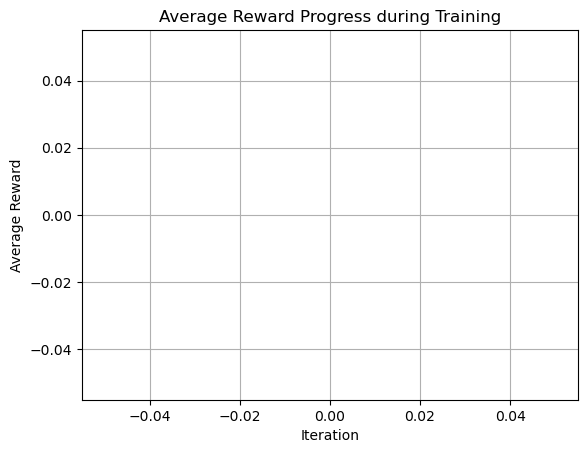





Running accel_model_14x14 with config: {'name': 'accel_model_14x14', 'grid_size': 14, 'train_steps': 3920, 'total_iterations': 2744, 'test_every_n_iterations': 40, 'replay_prob': 0.8, 'level_buffer_size': 256, 'initial_fill_size': 128, 'regret_threshold': 0.0, 'n_envs': 20, 'test_on_levels': 100, 'edit_levels': True, 'easy_start': False, 'domain_randomization': False, 'lr': 0.0001, 'batch_size': 128}
Initializing student model PPO...
Populating buffer with 128 initial levels with regret > 0.0...

Main training loop...

=== ITERATION 1/2744 SKIPPED: 0 ===

=== ITERATION 21/2747 SKIPPED: 3 ===

=== ITERATION 41/2750 SKIPPED: 6 ===

=== ITERATION 61/2755 SKIPPED: 11 ===

=== ITERATION 81/2756 SKIPPED: 12 ===

=== ITERATION 101/2760 SKIPPED: 16 ===

=== ITERATION 121/2764 SKIPPED: 20 ===

=== ITERATION 141/2765 SKIPPED: 21 ===

=== ITERATION 161/2768 SKIPPED: 24 ===

=== ITERATION 181/2772 SKIPPED: 28 ===

=== ITERATION 201/2773 SKIPPED: 29 ===

=== ITERATION 221/2776 SKIPPED: 32 ===



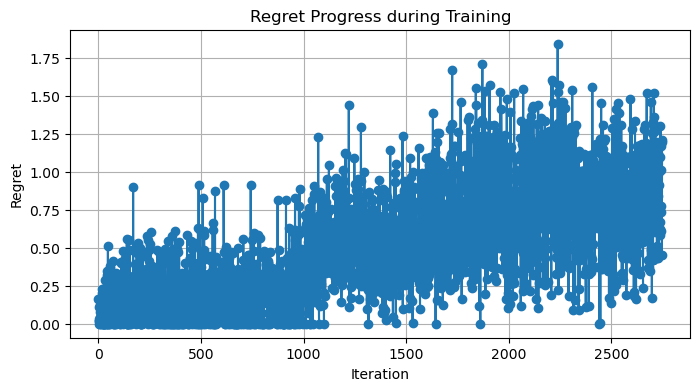


Done. Final buffer size: 256
Top-5 hardest levels (config, regret):
1. regret=1.84611, config={'width': 14, 'height': 14, 'num_blocks': 29, 'start_pos': (11, 10), 'goal_pos': (12, 12), 'edited': True, 'seed_val': 542}
2. regret=1.70916, config={'width': 14, 'height': 14, 'num_blocks': 37, 'start_pos': (2, 7), 'goal_pos': (1, 1), 'edited': True, 'seed_val': 142}
3. regret=1.67177, config={'width': 14, 'height': 14, 'num_blocks': 47, 'start_pos': (2, 9), 'goal_pos': (12, 5), 'edited': True, 'seed_val': 1602}
4. regret=1.60555, config={'width': 14, 'height': 14, 'num_blocks': 19, 'start_pos': (6, 4), 'goal_pos': (4, 2), 'edited': True, 'seed_val': 322}
5. regret=1.59271, config={'width': 14, 'height': 14, 'num_blocks': 29, 'start_pos': (11, 10), 'goal_pos': (12, 12), 'edited': True, 'seed_val': 542}
Top-5 easiest levels (config, regret):
1. regret=1.04662, config={'width': 14, 'height': 14, 'num_blocks': 6, 'start_pos': (6, 4), 'goal_pos': (4, 2), 'edited': True, 'seed_val': 322}
2. regr

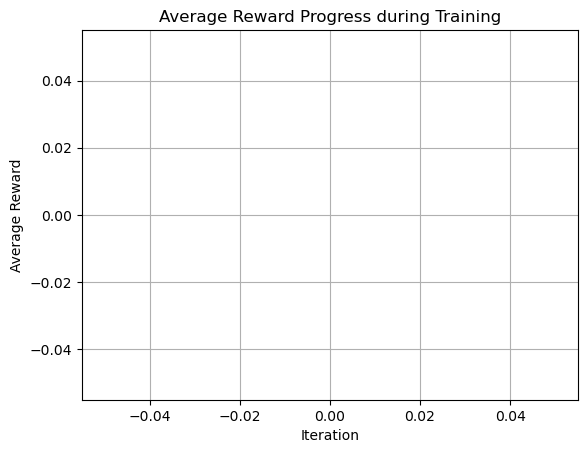

In [ ]:
import json

@dataclass
class Config:
    name: str = "model"
    grid_size: int = 6  # Grid size
    
    # Dynamic parameters (set in __post_init__)
    train_steps: int = None
    total_iterations: int = None
    test_every_n_iterations: int = None

    replay_prob: float = 0.8
    level_buffer_size: int = 256
    initial_fill_size: int = 128
    regret_threshold: float = 0.00
    n_envs: int = 20
    test_on_levels: int = 100
    edit_levels: bool = True
    easy_start: bool = True
    domain_randomization: bool = False
    lr: float = 1e-4
    batch_size: int = 128

    def update_dependent_params(self):
        """Recalculate dynamic parameters after updating grid_size."""
        self.train_steps = self.grid_size * self.grid_size * self.n_envs  # grid_size^2 * n_envs
        self.test_every_n_iterations = self.n_envs * 2  # test every n_envs * 2 iterations
        self.total_iterations = self.grid_size * self.grid_size * self.grid_size


if __name__ == "__main__":
    base_config = Config()  # elements are set to default values and dynamically calculated

    # Define different configuration
    configs = [
        #{"name": f"dr_model_6x6", "domain_randomization": True, "edit_levels": False, "easy_start": False, "grid_size": 6},
        #{"name": f"plr_model_6x6", "domain_randomization": False, "edit_levels": False, "easy_start": False, "grid_size": 6},
        #{"name": f"accel_model_6x6", "domain_randomization": False, "edit_levels": True, "easy_start": False, "grid_size": 6},
        #{"name": f"accel_model_easy_6x6", "domain_randomization": False, "edit_levels": True, "easy_start": True, "grid_size": 6},
        #{"name": f"dr_model_8x8", "domain_randomization": True, "edit_levels": False, "easy_start": False, "grid_size": 8},
        #{"name": f"plr_model_8x8", "domain_randomization": False, "edit_levels": False, "easy_start": False, "grid_size": 8},
        #{"name": f"accel_model_8x8", "domain_randomization": False, "edit_levels": True, "easy_start": False, "grid_size": 8},
        #{"name": f"accel_model_easy_8x8", "domain_randomization": False, "edit_levels": True, "easy_start": True, "grid_size": 8},
        #{"name": f"dr_model_10x10", "domain_randomization": True, "edit_levels": False, "easy_start": False, "grid_size": 10},
        #{"name": f"plr_model_10x10", "domain_randomization": False, "edit_levels": False, "easy_start": False, "grid_size": 10},
        #{"name": f"accel_model_10x10", "domain_randomization": False, "edit_levels": True, "easy_start": False, "grid_size": 10},
        #{"name": f"accel_model_easy_10x10", "domain_randomization": False, "edit_levels": True, "easy_start": True, "grid_size": 10},
        {"name": f"dr_model_14x14", "domain_randomization": True, "edit_levels": False, "easy_start": False, "grid_size": 14},
        #{"name": f"plr_model_14x14", "domain_randomization": False, "edit_levels": False, "easy_start": False, "grid_size": 14},
        {"name": f"accel_model_14x14", "domain_randomization": False, "edit_levels": True, "easy_start": False, "grid_size": 14},
        #{"name": f"accel_model_easy_14x14", "domain_randomization": False, "edit_levels": True, "easy_start": True, "grid_size": 14},     
    ]

    # Run models with different configurations
    for config_updates in configs:
        config = copy.deepcopy(base_config)  # Ensure each config is independent
        
        # Update attributes and recalculate dependent parameters
        for key, value in config_updates.items():
            setattr(config, key, value)
        config.update_dependent_params()  # Ensure recalculated values reflect changes

        # Save the dataclass as a dictionary
        with open(f"models/{config.name}.json", "w") as f:
            json.dump(asdict(config), f)
        
        print(f"Running {config.name} with config: {asdict(config)}")    
        main_accel_parallel(**asdict(config))
        print("\n\n============================================\n\n")


# Models evaluation

Models trained on 12x12 grid loaded successfully.
Evaluating 10 levels of difficulty 1 with 12 blocks on a 12x12 grid for model DR, ratio of blocks to grid size: 0.08
Evaluating 10 levels of difficulty 2 with 24 blocks on a 12x12 grid for model DR, ratio of blocks to grid size: 0.17
Evaluating 10 levels of difficulty 3 with 36 blocks on a 12x12 grid for model DR, ratio of blocks to grid size: 0.25

Evaluating 10 levels of difficulty 1 with 12 blocks on a 12x12 grid for model PLR, ratio of blocks to grid size: 0.08
Evaluating 10 levels of difficulty 2 with 24 blocks on a 12x12 grid for model PLR, ratio of blocks to grid size: 0.17
Evaluating 10 levels of difficulty 3 with 36 blocks on a 12x12 grid for model PLR, ratio of blocks to grid size: 0.25

Evaluating 10 levels of difficulty 1 with 12 blocks on a 12x12 grid for model ACCEL, ratio of blocks to grid size: 0.08
Evaluating 10 levels of difficulty 2 with 24 blocks on a 12x12 grid for model ACCEL, ratio of blocks to grid size: 0.17
Eva

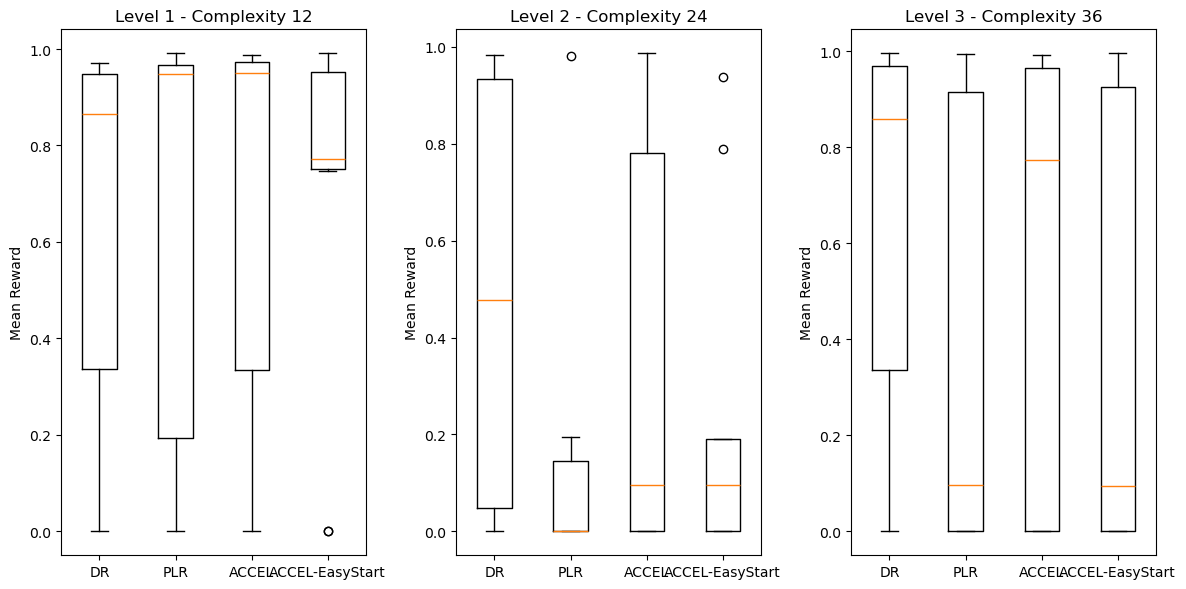

<Figure size 640x480 with 0 Axes>

In [37]:

# stopped at accel 10x10 (not finished)
evalute_models(load_dim = 12, grid_size = 12, n_eval_episodes = 5, num_levels_per_difficulty = 10)

In [63]:
# Create gif folder if it does not exist
if not os.path.exists("gifs"):
    os.makedirs("gifs")

# Load the models and evaluate them on a set of levels
evaluate_and_create_gifs(grid_size=16, num_levels=5, num_blocks=0.30*10*10)
print()

c:\Users\Utente\miniconda3\envs\accel_env_cuda\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Models trained on 16x16 grid loaded successfully.
Total rewards:
DR: 0.93
PLR: 0.97
ACCEL: 0.96
ACCEL-EasyStart: 0.00



## ENV TESTS

random_cnf: {'width': 12, 'height': 12, 'num_blocks': 12, 'start_pos': (3, 4), 'goal_pos': (10, 8), 'edited': False, 'seed_val': 463}


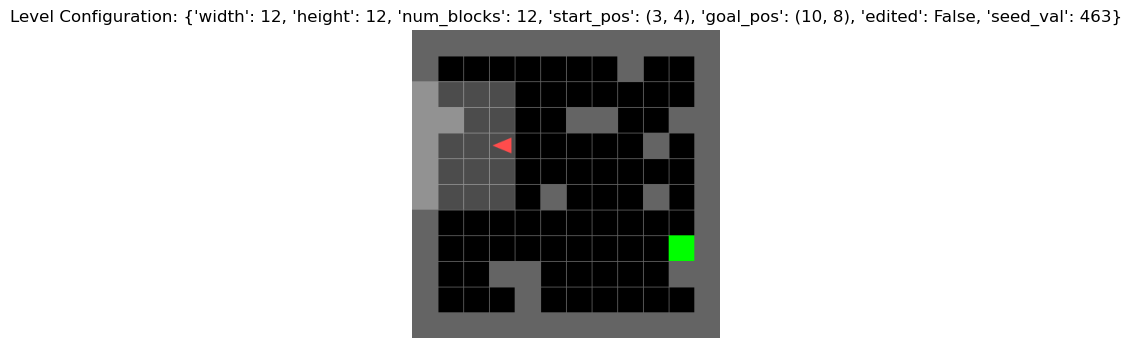

edited_cnf: {'width': 12, 'height': 12, 'num_blocks': 9, 'start_pos': (3, 4), 'goal_pos': (10, 8), 'edited': True, 'seed_val': 463}


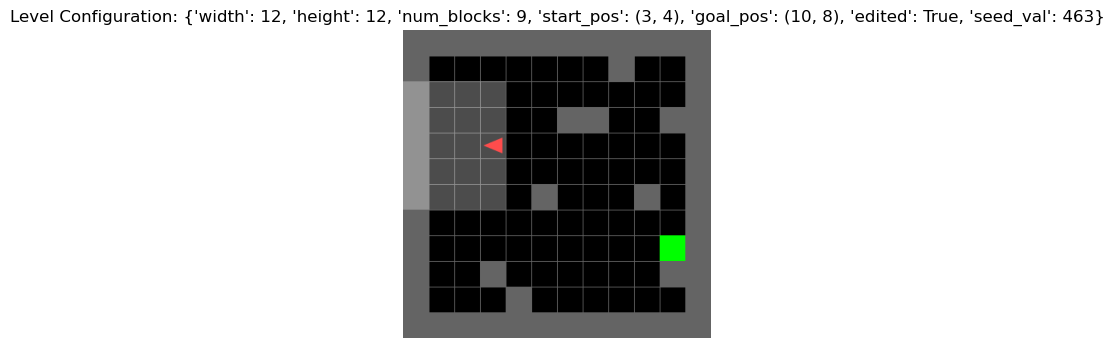

edited_cnf: {'width': 12, 'height': 12, 'num_blocks': 8, 'start_pos': (3, 4), 'goal_pos': (10, 8), 'edited': True, 'seed_val': 463}


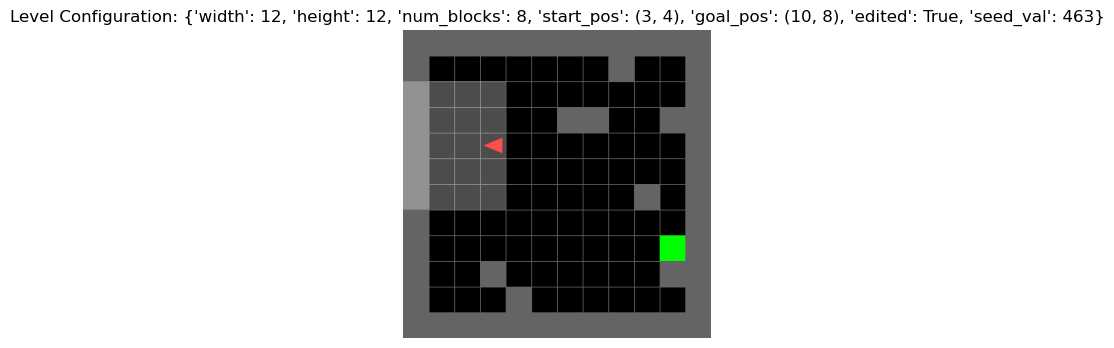

In [55]:
# Generate a random level and visualize it
random_cnf = random_config(12, num_blocks=12)
print("random_cnf:", random_cnf)
print_level_from_config(random_cnf)

# Edit the level and visualize it
edited_cnf = edit_config(random_cnf)
print("edited_cnf:", edited_cnf)
print_level_from_config(edited_cnf)

# Edit the level and visualize it
edited_cnf = edit_config(edited_cnf)
print("edited_cnf:", edited_cnf)
print_level_from_config(edited_cnf)

In [16]:
# evaluate using the standard sb3 evaluate_policy function
model_dr = PPO.load("models/dr_model_14x14")
#model_plr = PPO.load("models/plr_model_16x16")
model_accel = PPO.load("models/accel_model_14x14")
#model_accel_easy = PPO.load("models/accel_model_easy_16x16")

models = {"DR": model_dr, 'ACCEL': model_accel}


configs = [random_config(16, seed=i) for i in range(25)]

total_reward = 0

for model_name, model in models.items():
    total_reward = 0
    for config in configs:
        env = MyCustomGrid(config, solvable_only=True)
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)
        total_reward += mean_reward
        #print(f"Model: {model_name}, Reward: {mean_reward}")
    print(f"Total reward over 100 levels: {total_reward}")

Total reward over 100 levels: 5.885742247104645
Total reward over 100 levels: 3.940234422683716
